# Sensitivity analysis

## Biblioteka SALib i funkcja Ishigami

In [1]:
# import libraries
%load_ext autotime
from SALib.plotting.bar import plot as barplot
from SALib.sample import saltelli, fast_sampler, morris as morris_sample
from SALib.analyze import sobol, fast, morris
from SALib.test_functions import Ishigami
import numpy as np
import math

In [2]:
# Define the model inputs
problem = {
    'num_vars': 3,
    'names': ['x1', 'x2', 'x3'],
    'bounds': [[-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359]]
}

In [3]:
# Generate samples for SOBOL
param_values_sobol = saltelli.sample(problem, 1000)

In [4]:
# Evaluate Ishigami model
Y_Ishigami_sobol = Ishigami.evaluate(param_values_sobol)

In [5]:
# SOBOL METHOD
Si_sobol = sobol.analyze(problem, Y_Ishigami_sobol, print_to_console=True)

Parameter S1 S1_conf ST ST_conf
x1 0.307975 0.066591 0.560137 0.091963
x2 0.447767 0.049768 0.438722 0.043844
x3 -0.004255 0.060140 0.242845 0.022636

Parameter_1 Parameter_2 S2 S2_conf
x1 x2 0.012205 0.082936
x1 x3 0.251526 0.088660
x2 x3 -0.009954 0.059575


__Zadanie 1:__ Użyj innych algorytmów do tworzenia próbek i analizowania modelu dostępnych w SALib, przeanalizuj otrzymane wyniki a także czas wykonania algorytmów analizujących. - https://salib.readthedocs.io/en/latest/api.html. Wskazówka: dla metody fast należy użyć samplera fast_sampler, a dla metody morris samplera morris_sample.

## Użycie własnego modelu w bibliotece SALib

Poniżej został pokazany przykład badania wrażliwości modelu Dividend discount model -  https://en.wikipedia.org/wiki/Dividend_discount_model  Badamy wrażliwość modelu na cene divident w następnym roku jak i na tempo wzrostu wartości dividend. 

In [6]:
def evaluate(values):
    Y = np.zeros([values.shape[0]])
    D = 2 # next year's annual divident per share
    r = 0.12 # cost of equity
    g = 0.03 # constant growth rate of dividents
    
    for i, X in enumerate(values):
        Y[i] = X[0] / (r - X[1])
    return Y

# Define the model inputs
problem = {
    'num_vars': 2,
    'names': ['D', 'g',],
    'bounds': [[1, 5],
               [0.01, 0.1]]
}
# Generate samples for SOBOL
param_values_sobol = saltelli.sample(problem, 1000)
# Evaluate Ishigami model
Y_Ishigami_sobol = evaluate(param_values_sobol)
# SOBOL METHOD
Si_sobol = sobol.analyze(problem, Y_Ishigami_sobol, print_to_console=True)

Parameter S1 S1_conf ST ST_conf
D 0.324379 0.054949 0.414892 0.061461
g 0.600660 0.098573 0.679429 0.069549

Parameter_1 Parameter_2 S2 S2_conf
D g 0.082718 0.124210


__Zadanie 2:__ Zaimplementować własny model fizyczny/matematyczny/biznesowy i zbadać jego wrażliwość.

## Predator-prey model

In [7]:
from scipy import integrate
import pylab as p

In [8]:
simulationSteps = 100
startSimulationTime = 0
endSimulationTime = 15
sampleNum = 100

In [9]:
class PredatorPreyModel:
    simulationsResults = []
    initialPreyPopulation = 10
    initialPredatorPopulation = 5
    alfa = 1.
    beta = 0.2
    gamma = 1.5
    delta = 0.75
    
    def dX_dt(self, X, t):
          return np.array([ self.alfa*X[0] - self.beta*X[0]*X[1] ,
                         -self.gamma*X[1] + self.delta*self.beta*X[0]*X[1] ])

    def setupModel(self, values):
        for i, X in enumerate(values):
            # prey and pred populations at beginning
            predatorPreyPopulations = np.array([self.initialPreyPopulation, self.initialPredatorPopulation])
            t = np.linspace(startSimulationTime, endSimulationTime,  simulationSteps) 
            self.alfa = X[0] # !!! self.alfa, self.beta, self.gamma, self.delta
            self.beta = X[1]

            # calculate predator-prey 
            PPPolulationsAtStep, infodict = integrate.odeint(self.dX_dt, predatorPreyPopulations, t, full_output=True)
            self.simulationsResults.append(PPPolulationsAtStep)

    def getArrayOfModelValues(self, step):
        Y = np.zeros([len(self.simulationsResults)])
        for i in range(len(self.simulationsResults)):
            Y[i] = self.simulationsResults[i][step][0] # !!! [0] for preys, [1] for predators
        return Y


In [10]:
class ModifiedPredatorPreyModel:
    simulationsResults = []
    initialPreyPopulation = 10
    initialPredatorPopulation = 5
    alfa = 1.
    beta = 0.2
    gamma = 1.5
    delta = 0.75
    K = 10
    
    def dX_dt(self, X, t):
          return np.array([ self.alfa*X[0]*(1-X[0]/self.K) - self.beta*X[0]*X[1] ,
                         -self.gamma*X[1] + self.delta*self.beta*X[0]*X[1] ])

    def setupModel(self, values):
        for i, X in enumerate(values):
            # prey and pred populations at beginning
            predatorPreyPopulations = np.array([self.initialPreyPopulation, self.initialPredatorPopulation])
            t = np.linspace(startSimulationTime, endSimulationTime,  simulationSteps) 
            self.alfa = X[0] # !!! self.alfa, self.beta, self.gamma, self.delta
            self.beta = X[1] # !!!

            # calculate predator-prey 
            PPPolulationsAtStep, infodict = integrate.odeint(self.dX_dt, predatorPreyPopulations, t, full_output=True)
            self.simulationsResults.append(PPPolulationsAtStep)

    def getArrayOfModelValues(self, step):
        Y = np.zeros([len(self.simulationsResults)])
        for i in range(len(self.simulationsResults)):
            Y[i] = self.simulationsResults[i][step][0] # !!! [0] for preys, [1] for predators
        return Y

In [11]:
# Define the model inputs
problem = {
    'num_vars': 2,
    'names': ['alfa', 'beta'],
    'bounds': [[0.75, 1.25],
               [0.15, 0.25]]
}

In [12]:
# Generate samples
param_values = saltelli.sample(problem, sampleNum)

In [13]:
# Calculate sensivitness for every simulation step (model setup)
sensitivity = []
firstVariableSensitivity = []
secondVariableSensitivity = []
firstAndSecondVariableSensitivity = []

model = PredatorPreyModel() # ModifiedPredatorPreyModel() !!!
model.setupModel(param_values)

In [14]:
# Evaluate model for every step of simulation
for i in range(simulationSteps):
    # get array of model values at time step 'i'
    Y = model.getArrayOfModelValues(i)
    # analyze these values using sobol method
    Si = sobol.analyze(problem, Y, print_to_console=False)

    firstVariableSensitivity.append(Si['S1'][0])
    secondVariableSensitivity.append(Si['S1'][1])
    firstAndSecondVariableSensitivity.append(Si['S2'][0,1])

/usr/local/lib/python3.7/site-packages/SALib/analyze/sobol.py:93: RuntimeWarning: invalid value encountered in true_divide
  Y = (Y - Y.mean()) / Y.std()


Text(0.5, 1.0, 'Sensitivness of alfa & beta in time for prey')

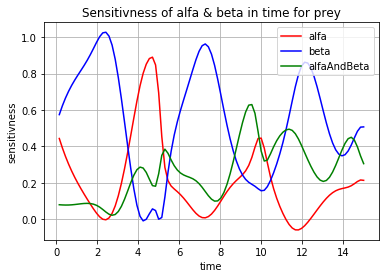

In [15]:
# plot results
t = np.linspace(startSimulationTime, endSimulationTime,  simulationSteps)
f1 = p.figure()
p.plot(t, firstVariableSensitivity, 'r-', label='alfa')
p.plot(t, secondVariableSensitivity, 'b-', label='beta')
p.plot(t, firstAndSecondVariableSensitivity, 'g-', label='alfaAndBeta')
p.grid()
p.legend(loc='best')
p.xlabel('time')
p.ylabel('sensitivness')
p.title('Sensitivness of alfa & beta in time for prey')

__Zadanie 3:__ Zbadać wrażliwość zmiennych alfa, beta gamma, delta modelu predator-prey lub zmodyfikowanego model predator-prey. Należy zbadać to dla predator jak i dla prey.